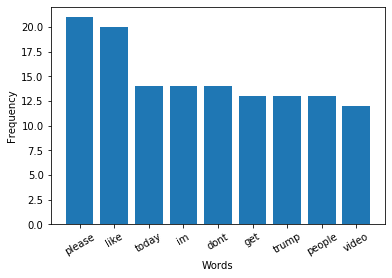

In [19]:
# -*- coding: utf-8 -*-
"""
Created on Sat Dec  7 15:10:47 2019

@author: Parth
"""
import settings
import mysql.connector
import pandas as pd
import time
import itertools
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px
import datetime
from IPython.display import clear_output
import plotly.offline as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import tweepy
import numpy as np
import re
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
consumer_key='rNrnFupaEqKt0eb7hjbdHKdWg'
consumer_secret= 'DTTMoQOrCBmngaXmOnFhrBjdjwtT54x0AbGvNwwuqyYNWwEvc7'
access_token='1002268050513575936-gGrQUmDiMyCxO2Y88lc3ojqNzbtLGm'
access_token_secret='G572YTe2S5TQTTaXhFvl1WyNopa8ilrkgWSlCXBZQwU4C'
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth,wait_on_rate_limit=True)


db_connection = mysql.connector.connect(
    host="localhost",
    user="root",
    passwd="parth123n@#*",
    database="indiaagainstbjpdb",
    charset = 'utf8'
)


timenow = (datetime.datetime.utcnow() - datetime.timedelta(hours=0, minutes=30)).strftime('%Y-%m-%d %H:%M:%S')
query = "SELECT id_str, text, created_at, polarity, user_location FROM {}" \
                 .format('IndiaAgainstBJP')
df = pd.read_sql(query, con=db_connection)
# UTC for date time at default

#df['created_at'] = pd.to_datetime(df['created_at'])


# Clean and transform data to enable time series
result = df.groupby([pd.Grouper(key='created_at', freq='2s'), 'polarity']).count().unstack(fill_value=0).stack().reset_index()
#result['created_at'] = pd.to_datetime(result['created_at']).apply(lambda x: x.strftime('%m-%d %H:%M'))
#result = df
result = result.rename(columns={"id_str": "Num of '{}' mentions".format('IndiaAgainstBJP'), "created_at":"Time in UTC"})
time_series = result["Time in UTC"][result['polarity']==0].reset_index(drop=True)
fig = px.line(result, x='Time in UTC', y="Num of '{}' mentions".format('IndiaAgainstBJP'), color='polarity')
fig.show()
time.sleep(60)

#fig = px.line(result, x='Time in UTC', y="Num of '{}' mentions".format(settings.TRACK_WORDS[0]), color='polarity')
#fig.show()
#time.sleep(60)
'''
df=df.set_index('created_at')

sns.set(rc={'figure.figsize':(11, 4)})

df['polarity'].plot(linewidth=0.7)
'''



content = ' '.join(df["text"])
content = re.sub(r"http\S+", "", content)
content = content.replace('RT ', ' ').replace('&amp;', 'and')
content = re.sub('[^A-Za-z0-9]+', ' ', content)
content = content.lower()

tokenized_word = word_tokenize(content)
stop_words=set(stopwords.words("english"))
filtered_sent=[]
for w in tokenized_word:
    if w not in stop_words:
        filtered_sent.append(w)
fdist = FreqDist(filtered_sent)
fd = pd.DataFrame(fdist.most_common(10), columns = ["Word","Frequency"]).drop([0]).reindex()

y=fd['Frequency']
x=fd['Word']

index=np.arange(len(x))
plt.bar(index,y)
plt.xlabel('Words',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.xticks(index,x,fontsize=10,rotation=30)
plt.show()






















In [15]:

from plotly.subplots import make_subplots
fig = make_subplots(rows=2, cols=2,column_widths=[1, 0.4],row_heights=[0.6, 0.4],specs=[[{"type": "scatter", "rowspan": 2},{"type": "choropleth"}],[None, {"type": "bar"}]])


fig.add_trace(go.Scatter(x=time_series,y=result["Num of '{}' mentions".format(settings.TRACK_WORDS)][result['polarity']==0].reset_index(drop=True),name="Neural",opacity=0.8), row=1, col=1)   

fig.add_trace(go.Scatter(x=time_series,y=result["Num of '{}' mentions".format(settings.TRACK_WORDS)][result['polarity']==-1].reset_index(drop=True),name="Negative",opacity=0.8), row=1, col=1)

fig.add_trace(go.Scatter(x=time_series,y=result["Num of '{}' mentions".format(settings.TRACK_WORDS)][result['polarity']==1].reset_index(drop=True),name="Positive",opacity=0.8), row=1, col=1)

fig.add_trace(go.Bar(x=fd["Word"], y=fd["Frequency"],name="Freq Dist"), row=2, col=2)

fig.update_traces(marker_color='rgb(59, 89, 152)',marker_line_color='rgb(8,48,107)',marker_line_width=0.5, opacity=0.7, row=2, col=2)

fig.show()